#1 . Necessar imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

# 2 . Define the brarrier-logarithm objective of the dual  and its gradient and hessien

In [2]:
#objective with the barrier log
def obj(Q,c,t,v):
  return t*(0.5*v.T @ Q @ v - np.sum(v)) - np.sum(np.log(c - v)) - np.sum(np.log(v))
  
def grad(Q,c,t,v):
  return t*(Q @v -1) + 1/(c-v) - 1/v

def hess(Q,c,t,v):
  return t*Q  + np.diag(1/((c-v)*(c-v)))+ np.diag(1/(v*v))

# 3 . Centering step of the barrier method

In [3]:
def centering_step(Q,c,t,v0,eps,alpha=0.5,beta=0.9):

  #saving v_i (evolution of v along iterations)in a list v_record
  v_record=[v0]

  v = v0
  test = True
  gradient = grad(Q,c,t,v)
  hessien = hess(Q,c,t,v)
  Z = np.linalg.solve(hessien,gradient)
  decrement = gradient.T@Z
  while decrement > 2*eps:
    
    #newton step
    delta_v = -Z

    #backtracking line search
    minimum = np.inf
    for i in range(len(v)):
      if (delta_v[i]>0) and (minimum > (c-v[i])/delta_v[i]):
        minimum = (c-v[i])/delta_v[i]
      if (delta_v[i]<0) and (minimum > -v[i]/delta_v[i]):
        minimum = -v[i]/delta_v[i]
    h = min(1,0.99*minimum)
    
    while (np.all((v+h*delta_v) < c)) and (np.all((v+h*delta_v) >0 )) and (obj(Q,c,t,v+h*delta_v) >= obj(Q,c,t,v)- alpha*h*decrement) :
      h = beta*h
    
    #update v
    v = v + h*delta_v
    v_record.append(v)

    #update the newton decrement 
    gradient = grad(Q,c,t,v)
    hessien = hess(Q,c,t,v)
    Z = np.linalg.solve(hessien,gradient)
    decrement = gradient.T@Z
  
  return v_record
    

# 4 . Barrier Method algorithm

In [78]:
def barr_method(Q,c,v0,mu,eps,alpha=0.5,beta =0.9):
  # initialization
  v_seq = [v0]
  inner_iter= []
  m = len(v0)
  t = 1

  while t <= m/eps:
      v = centering_step(Q,c, t, v_seq[-1], eps=eps, alpha=alpha, beta=beta)[-1]
      if inner_iter==[]:
        inner_iter.append(len(v))
      else: 
        inner_iter.append(len(v)+inner_iter[-1])
      v_seq.append(v)
      t *= mu

  return v_seq,inner_iter

# 5 . Time for tests : exampe of a bivariate-distributed data

In [5]:
#generate random data and y

n = 2
m = 100


#define the dual problem's parameter

y = 2*np.random.randint(2,size=m)-np.ones(m) #labels

mean1 = -2*np.ones(n)
cov1 = 0.5*np.eye(n)

mean2 = 2*np.ones(n)
cov2 = np.eye(n)

data = np.zeros((n,m))
for i in range(m):
  if i%2==0:
    data[:,i] = np.random.multivariate_normal(mean1, cov1)
  else:
    data[:,i] = np.random.multivariate_normal(mean2, cov2)
U = data@np.diag(y)
Q =U.T@U



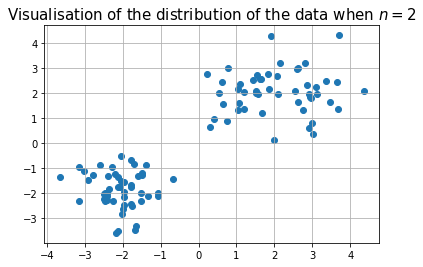

In [25]:
if n ==2: 
  plt.scatter(data[0],data[1])
  plt.title('Visualisation of the distribution of the data when $n=2$',fontsize=15)
  plt.grid()

> **Remark :** I choose means and covariances of the two normal distributions that help us even visually distinfuish the two classes


In [47]:
def slack_comp(U,v,c):
  z= np.zeros(v.shape)
  for i in range(len(v)):
    if abs(v[i] - c) < 1e-4:
      z[i] = 1- (U.T@U@v)[i]
  return z

Gap between the dual and the primal : p* -d* =  4.0792861000227276e-07


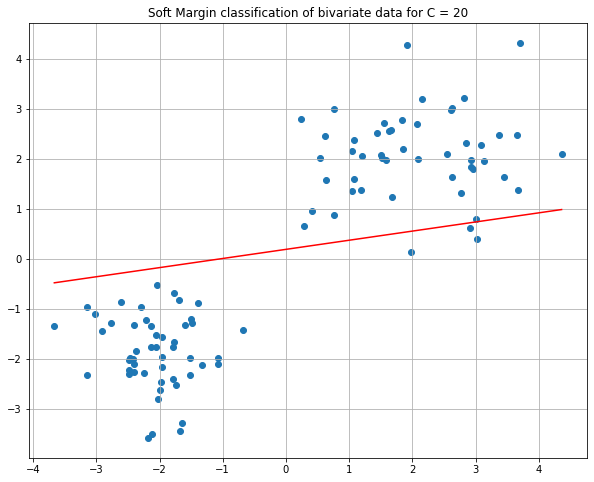

In [76]:
#Applying the barrier method

c = 20

#the dual solution
v_seq = barr_method(Q,c,0.5*c*np.ones(m),mu,eps=1e-7,alpha=0.1,beta =0.7)[0]
v_star = v_seq[-1]
g_seq = [-0.5*v.T @ Q @ v + np.sum(v) for v in v_seq]
g_star = g_seq[-1]

#deduce the primal solution
w_star = U@v_star
z_star = slack_comp(U,v_star,c)

#test strong duality:
f_star = 0.5*w_star.T@w_star + c*np.sum(z_star)
print("Gap between the dual and the primal : p* -d* = ",f_star - g_star )


if n==2:
    plt.figure(figsize=(10,8))
    plt.scatter(data[0],data[1])
    plt.plot([min(data[0]),max(data[0]) ], [w_star[0]*min(data[0]),w_star[1]*max(data[0])],c='red')
    plt.grid()
    plt.title("Soft Margin classification of bivariate data for C = "+str(c))
    plt.show()

> **Comment :** we notice that the $p^*- d^*  \approx 4\times 10^{-7}$ . In fact , this is compatible with the strong duality of the problem. Moreover , the classification is quiet good : the line (whoose equation is $y = w^T x$) is separating efficiently the two clusters.

# 5 . Impact of the regularisation term $C$ on the convergence

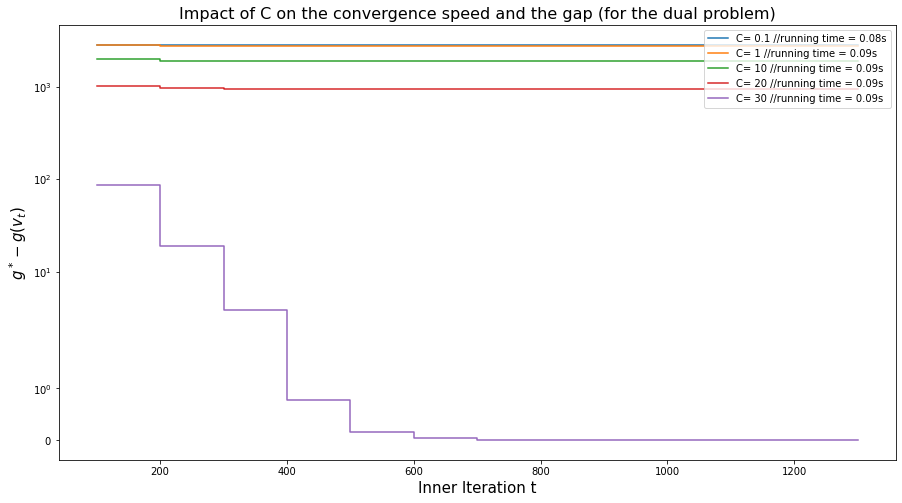

In [91]:
c_values = [0.1,1,10,20,30]
mu = 5
times=[]
results=[]
iterations=[]

for c in c_values:
  t =time.time()
  v_seq , inner_iter = barr_method(Q,c,0.5*c*np.ones(m),mu,eps=1e-7,alpha=0.1,beta =0.7)
  iterations.append(inner_iter)
  t = time.time() -t
  results.append(v_seq)
  times.append(t)


g_values = [[-0.5*v.T @ Q @ v + np.sum(v) for v in results[i]] for i in range(len(results))]
g_star = -np.infty
v_star = None
index_min =0
for i in range(len(results)):
    for g in g_values[i]:
        if g_star < g:
            g_star = g
            v_star = results[i][-1]
            index_max = i

#deduce the primal solution
w_star = U@v_star
z_star = slack_comp(U,v_star,c_values[index_max])
f_values=[[0.5*v.T@U.T@U@v +c_values[i]*np.sum(slack_comp(U,v,c_values[i])) for v in results[i]] for i in range(len(results))]

#plots
plt.figure(figsize=(15,8))
plt.xlabel('Inner Iteration t',fontsize = 15)
plt.ylabel('$g^* - g(v_t) $',fontsize=15)
plt.yscale('symlog')
plt.title('Impact of C on the convergence speed and the gap (for the dual problem)',fontsize=16)
for i in range(len(results)):
    plt.step(iterations[i], g_star - g_values[i][1:],where="post",label='C= {}'.format(c_values[i])+' //running time = {}'.format(round(times[i],2))+'s')
plt.legend(loc="upper right")
plt.show()


**Comments:**

> 1. $C$ allows the control of the trade-off between the number of misclassified points and the width of the margin. A good tuning of C may requires  exhaustive search (we can use  cross-validation) 

> 2. Horizontal steps represents the centering step: they are the inner iterations. Meanwile, the vertical segments are induced by the barrier iterations (once the centered point is derived): they are the outer iterations. When we have a 'long' horizontal segment, this means that the centering step required a lot of iterations and actually. We notice that the inner iterations do not depend on $C$ : the centering step requires the same number of executions even when $C$ changes.

> 3. When $C$ is too small, we remain 'far from' the best value $g^*$. When  $C$ increases, the gap decreases but if $C$ exceeds a certain value, the algorithm doesn't seem to converge (I tried for example C=1000 and I stopped its running after a few minutes)

